In [8]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import datetime
import numpy.ma as ma
import glob
import os
from scipy.stats import pearsonr
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import re


In [45]:
folder_path = r"C:\Users\ollie\MSc Data Science\Group Project\finalNDVIdata"
file_list = sorted(glob.glob(os.path.join(folder_path, "*.nc")))
nc_files_dict = {}
# Gets all filenames and the month & year of the files to create a dictionary
for file in file_list:
    filename = os.path.basename(file)  
    parts = filename.split('_')
    if len(parts) >= 4:
        datetime_str = parts[3]  
        year = datetime_str[:4]
        month = datetime_str[4:6]
        key = f"{year}-{month}"
        nc_files_dict[key] = file
nc_files_dict

{'1999-01': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199901210000_GLOBE_VGT_V3.0.1.nc',
 '1999-02': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199902210000_GLOBE_VGT_V3.0.1.nc',
 '1999-03': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199903210000_GLOBE_VGT_V3.0.1.nc',
 '1999-04': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199904210000_GLOBE_VGT_V3.0.1.nc',
 '1999-05': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199905210000_GLOBE_VGT_V3.0.1.nc',
 '1999-06': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199906210000_GLOBE_VGT_V3.0.1.nc',
 '1999-07': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199907210000_GLOBE_VGT_V3.0.1.nc',
 '1999-08': 'C:\\Users\\ollie\\MSc Data Science\\Group Project\\finalNDVIdata\\c_gls_NDVI_199908210000_GLOBE_VGT_V3.0.1.nc',


In [46]:
#Interchangable between crane, stork and flamingo data as all in same format and require the same initial cleaning
crane_df = pd.read_csv(r"C:\Users\ollie\MSc Data Science\Group Project\stork testing\Flamingo 2001-2020.csv")
crane_df["OBSERVATION DATE"] = pd.to_datetime(crane_df["OBSERVATION DATE"], format="%Y-%m-%d", errors = "coerce")
crane_df = crane_df.dropna(subset = ["OBSERVATION DATE"])
crane_df["OBSERVATION COUNT"] = pd.to_numeric(crane_df['OBSERVATION COUNT'], errors='coerce')
#crane_df[crane_df["OBSERVATION DATE"].isna()]
crane_df

,GLOBAL UNIQUE IDENTIFIER,OBSERVATION COUNT,COUNTRY,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,DURATION MINUTES
0,URN:CornellLabOfOrnithology:EBIRD:OBS893538867,1.0,United Arab Emirates,25.169707,55.432797,2001-12-15,NaN,NaN
1,URN:CornellLabOfOrnithology:EBIRD:OBS843912433,1.0,Oman,25.672686,56.271832,2001-04-19,NaN,NaN
2,URN:CornellLabOfOrnithology:EBIRD:OBS2143453118,1.0,South Africa,-26.350960,28.511238,2001-02-11,NaN,NaN
3,URN:CornellLabOfOrnithology:EBIRD:OBS2112747536,3.0,South Africa,-26.350960,28.511238,2001-01-20,NaN,NaN
4,URN:CornellLabOfOrnithology:EBIRD:OBS2218298031,NaN,South Africa,-26.350960,28.511238,2001-10-26,06:30:00,300.0
...,...,...,...,...,...,...,...,...
126344,URN:CornellLabOfOrnithology:EBIRD:OBS855013575,11.0,Spain,36.672825,-4.456029,2020-01-23,16:20:00,78.0
126345,URN:CornellLabOfOrnithology:EBIRD:OBS884410378,8.0,Spain,36.672825,-4.456029,2020-03-27,08:35:00,360.0
126346,URN:CornellLabOfOrnithology:EBIRD:OBS856162585,7.0,Spain,36.672825,-4.456029,2020-01-26,09:31:00,114.0
126347,URN:CornellLabOfOrnithology:EBIRD:OBS938617073,8.0,Portugal,38.747858,-8.922272,2020-06-06,17:00:00,69.0


# Finding NDVI for each observation

In [50]:
crane_df["key"] = crane_df["OBSERVATION DATE"].apply(lambda d: f"{d.year}-{d.month:02d}") # Creates key based on month and year of observation

grouped = crane_df.groupby("key") # Group sightings by the key

extracted_data = []

# Loops through each group
for key, group in grouped:
    nc_file = nc_files_dict.get(key)
    if nc_file:
        with xr.open_dataset(nc_file) as ds:
            ds = ds.drop_vars(["time", "NDVI_unc", "NOBS", "QFLAG", "TIME_GRID", "crs"])
            ds = ds.sel(time = 0)
            ds_masked = ds.where(ds.NDVI <= 0.92)
            del ds
            for idx, row in group.iterrows():
                # Extract NDVI at the nearest grid point for each observation
                ndvi = ds_masked['NDVI'].sel(lat=row["LATITUDE"], lon=row["LONGITUDE"], method="nearest").item()
                extracted_data.append([row["GLOBAL UNIQUE IDENTIFIER"], row["OBSERVATION DATE"], row["LATITUDE"], row["LONGITUDE"], ndvi])
        print(key)
        del ds_masked
    else:
        #print(f"No NDVI file found for {key}")
        pass


df = pd.DataFrame(extracted_data, columns=["unique identifier", "date", "latitude", "longitude", "NDVI"])
    

2001-01
2001-02
2001-03
2001-04
2001-05
2001-06
2001-07
2001-08
2001-09
2001-10
2001-11
2001-12
2002-01
2002-02
2002-03
2002-04
2002-05
2002-06
2002-07
2002-08
2002-09
2002-10
2002-11
2002-12
2003-01
2003-02
2003-03
2003-04
2003-05
2003-06
2003-07
2003-08
2003-09
2003-10
2003-11
2003-12
2004-01
2004-02
2004-03
2004-04
2004-05
2004-06
2004-07
2004-08
2004-09
2004-10
2004-11
2004-12
2005-01
2005-02
2005-03
2005-04
2005-05
2005-06
2005-07
2005-08
2005-09
2005-10
2005-11
2005-12
2006-01
2006-02
2006-03
2006-04
2006-05
2006-06
2006-07
2006-08
2006-09
2006-10
2006-11
2006-12
2007-01
2007-02
2007-03
2007-04
2007-05
2007-06
2007-07
2007-08
2007-09
2007-10
2007-11
2007-12
2008-01
2008-02
2008-03
2008-04
2008-05
2008-06
2008-07
2008-08
2008-09
2008-10
2008-11
2008-12
2009-01
2009-02
2009-03
2009-04
2009-05
2009-06
2009-07
2009-08
2009-09
2009-10
2009-11
2009-12
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05


In [51]:
print(df.isna().sum())
df

unique identifier       0
date                    0
latitude                0
longitude               0
NDVI                 8569
dtype: int64


,unique identifier,date,latitude,longitude,NDVI
0,URN:CornellLabOfOrnithology:EBIRD:OBS2112747536,2001-01-20,-26.350960,28.511238,0.376
1,URN:CornellLabOfOrnithology:EBIRD:OBS238318550,2001-01-28,-26.350960,28.511238,0.376
2,URN:CornellLabOfOrnithology:EBIRD:OBS2139719073,2001-01-28,-26.350960,28.511238,0.376
3,URN:CornellLabOfOrnithology:EBIRD:OBS2112632954,2001-01-14,-26.350960,28.511238,0.376
4,URN:CornellLabOfOrnithology:EBIRD:OBS2130828494,2001-01-21,-26.350960,28.511238,0.376
...,...,...,...,...,...
126344,URN:CornellLabOfOrnithology:EBIRD:OBS937592633,2020-06-04,37.094690,-8.331370,0.340
126345,URN:CornellLabOfOrnithology:EBIRD:OBS946399240,2020-06-20,15.985320,-16.480912,0.032
126346,URN:CornellLabOfOrnithology:EBIRD:OBS937344819,2020-06-04,37.018826,-7.906452,0.248
126347,URN:CornellLabOfOrnithology:EBIRD:OBS950804816,2020-06-28,43.370086,4.798579,-0.040


In [52]:
df.to_csv(r"C:\Users\ollie\MSc Data Science\Group Project\stork testing\flamingo_ndvi_final.csv") # Saves final dataset

In [4]:
crane_df["key"] = crane_df["OBSERVATION DATE"].apply(lambda d: f"{d.year}-{d.month:02d}")

# Group sightings by the key
grouped = crane_df.groupby("key")

In [5]:
df

,unique identifier,date,latitude,longitude,NDVI
0,URN:CornellLabOfOrnithology:EBIRD:OBS1018277880,1999-01-16,40.221876,-6.042400,0.504
1,URN:CornellLabOfOrnithology:EBIRD:OBS186002084,1999-01-10,38.121593,-7.264710,0.440
2,URN:CornellLabOfOrnithology:EBIRD:OBS1018499087,1999-01-30,40.164916,-6.084014,0.532
3,URN:CornellLabOfOrnithology:EBIRD:OBS772904137,1999-01-06,23.324383,71.828233,0.352
4,URN:CornellLabOfOrnithology:EBIRD:OBS1011597907,1999-01-29,27.161906,77.522793,0.408
...,...,...,...,...,...
85790,URN:CornellLabOfOrnithology:EBIRD:OBS942289055,2020-06-13,58.363592,14.915583,0.788
85791,URN:CornellLabOfOrnithology:EBIRD:OBS944903839,2020-06-18,61.154478,21.450309,NaN
85792,URN:CornellLabOfOrnithology:EBIRD:OBS939264716,2020-06-02,58.278908,13.528970,0.760
85793,URN:CornellLabOfOrnithology:EBIRD:OBS941869080,2020-06-13,65.530157,28.761518,0.712


In [18]:
#Gets all observations within the timeframe of our investigation
filtered_crane_df = crane_df.loc[(crane_df['OBSERVATION DATE'] >= '2001-01-01') & (crane_df['OBSERVATION DATE'] <= '2020-06-30')] 
filtered_crane_df.sort_values(by = ["OBSERVATION DATE"])


,GLOBAL UNIQUE IDENTIFIER,OBSERVATION COUNT,COUNTRY,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,DURATION MINUTES,key
7381,URN:CornellLabOfOrnithology:EBIRD:OBS1758479600,NaN,Spain,38.982031,-6.497383,2001-01-01,10:45:00,NaN,2001-01
7247,URN:CornellLabOfOrnithology:EBIRD:OBS700232303,858.0,France,43.510457,-1.352713,2001-01-04,NaN,180.0,2001-01
7249,URN:CornellLabOfOrnithology:EBIRD:OBS1622168516,858.0,France,43.510457,-1.352713,2001-01-04,NaN,180.0,2001-01
7354,URN:CornellLabOfOrnithology:EBIRD:OBS485343808,1.0,Kuwait,29.323448,47.831254,2001-01-04,11:00:00,30.0,2001-01
7363,URN:CornellLabOfOrnithology:EBIRD:OBS1741190429,23.0,Spain,40.856507,-4.762938,2001-01-07,10:00:00,NaN,2001-01
...,...,...,...,...,...,...,...,...,...
98003,URN:CornellLabOfOrnithology:EBIRD:OBS950472949,2.0,Finland,61.343097,24.626852,2020-06-30,12:13:00,52.0,2020-06
96069,URN:CornellLabOfOrnithology:EBIRD:OBS949994066,2.0,Finland,62.132530,21.331301,2020-06-30,11:23:00,161.0,2020-06
83097,URN:CornellLabOfOrnithology:EBIRD:OBS1253807636,1.0,Poland,53.741559,14.600136,2020-06-30,18:41:00,75.0,2020-06
99666,URN:CornellLabOfOrnithology:EBIRD:OBS950145261,2.0,Finland,60.189497,24.819102,2020-06-30,19:41:00,65.0,2020-06


## Getting Non_presence Data

In [4]:
crane_df = pd.read_csv(r"C:\Users\ollie\MSc Data Science\Group Project\clean_crane_data.csv")
crane_df["OBSERVATION DATE"] = pd.to_datetime(crane_df["OBSERVATION DATE"], format="%d/%m/%Y", errors = "coerce")
crane_df = crane_df.dropna(subset = ["OBSERVATION DATE"])
crane_df["OBSERVATION COUNT"] = pd.to_numeric(crane_df['OBSERVATION COUNT'], errors='coerce')
#crane_df[crane_df["OBSERVATION DATE"].isna()]
filtered_crane_df = crane_df.loc[(crane_df['OBSERVATION DATE'] >= '2001-01-01') & (crane_df['OBSERVATION DATE'] <= '2020-06-30')]
filtered_crane_df

,GLOBAL UNIQUE IDENTIFIER,OBSERVATION COUNT,COUNTRY,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,DURATION MINUTES
7018,URN:CornellLabOfOrnithology:EBIRD:OBS1550269990,NaN,Sweden,59.510046,12.371991,2001-06-16,08:00:00,240.0
7019,URN:CornellLabOfOrnithology:EBIRD:OBS1241571196,1.0,Netherlands,52.451825,5.370254,2001-03-11,08:00:00,105.0
7020,URN:CornellLabOfOrnithology:EBIRD:OBS964505541,10.0,Germany,49.459170,8.678565,2001-11-05,NaN,NaN
7021,URN:CornellLabOfOrnithology:EBIRD:OBS1684568169,3.0,Sweden,60.436609,16.452448,2001-09-22,08:12:00,285.0
7022,URN:CornellLabOfOrnithology:EBIRD:OBS105630429,1.0,Sweden,58.461900,15.555868,2001-05-21,NaN,NaN
...,...,...,...,...,...,...,...,...
102127,URN:CornellLabOfOrnithology:EBIRD:OBS907974657,5.0,Belarus,51.893125,24.270556,2020-05-01,07:04:00,124.0
102128,URN:CornellLabOfOrnithology:EBIRD:OBS849476324,2.0,Spain,40.986812,-6.062696,2020-01-10,09:26:00,70.0
102130,URN:CornellLabOfOrnithology:EBIRD:OBS876975681,1.0,Sweden,59.592077,16.271463,2020-03-11,07:13:00,NaN
102132,URN:CornellLabOfOrnithology:EBIRD:OBS934788467,14.0,Poland,54.630264,18.485380,2020-05-30,14:04:00,NaN


In [80]:
ndvi_non_presence = []
lag_month = []

#Creates key offset by 6 months
filtered_crane_df["key"] = (filtered_crane_df["OBSERVATION DATE"] - pd.DateOffset(months = 6)).apply(lambda d: f"{d.year}-{d.month:02d}") 
filtered_crane_df

grouped = filtered_crane_df.groupby("key")

for i, group in grouped:
    past_date_key = i
    lag_nc_file = nc_files_dict.get(past_date_key)
    if lag_nc_file:
        lag_month.append(past_date_key.split("-")[1])
        with xr.open_dataset(lag_nc_file) as lag_ds:
            lag_ds = lag_ds.drop_vars(["time", "NDVI_unc", "NOBS", "QFLAG", "TIME_GRID", "crs"])
            lag_ds = lag_ds.sel(time = 0)
            lag_ds_masked = lag_ds.where(lag_ds.NDVI <= 0.92)
            del lag_ds
            
            for idx, row in group.iterrows():
                            # Extract NDVI at the nearest grid point for each observation
                            lag_ndvi = lag_ds_masked['NDVI'].sel(lat=row["LATITUDE"], lon=row["LONGITUDE"], method="nearest").item()
                            ndvi_non_presence.append(lag_ndvi)
                            del lag_ndvi
        print(past_date_key)
        del lag_ds_masked
    else:
        print("not found")
    

C:\Users\ollie\AppData\Local\Temp\ipykernel_20988\602604411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crane_df["key"] = (filtered_crane_df["OBSERVATION DATE"] - pd.DateOffset(months = 6)).apply(lambda d: f"{d.year}-{d.month:02d}")


2000-07
58
2000-08
104
2000-09
165
2000-10
220
2000-11
272
2000-12
305
2001-01
332
2001-02
351
2001-03
377
2001-04
422
2001-05
503
2001-06
584
2001-07
647
2001-08
698
2001-09
758
2001-10
811
2001-11
871
2001-12
896
2002-01
918
2002-02
928
2002-03
952
2002-04
1009
2002-05
1070
2002-06
1134
2002-07
1196
2002-08
1256
2002-09
1337
2002-10
1387
2002-11
1478
2002-12
1520
2003-01
1548
2003-02
1571
2003-03
1601
2003-04
1665
2003-05
1737
2003-06
1788
2003-07
1843
2003-08
1893
2003-09
1980
2003-10
2080
2003-11
2177
2003-12
2221
2004-01
2244
2004-02
2287
2004-03
2323
2004-04
2413
2004-05
2503
2004-06
2585
2004-07
2653
2004-08
2712
2004-09
2789
2004-10
2897
2004-11
3014
2004-12
3043
2005-01
3093
2005-02
3139
2005-03
3190
2005-04
3277
2005-05
3335
2005-06
3401
2005-07
3482
2005-08
3542
2005-09
3630
2005-10
3821
2005-11
3967
2005-12
4018
2006-01
4054
2006-02
4103
2006-03
4156
2006-04
4252
2006-05
4336
2006-06
4413
2006-07
4521
2006-08
4589
2006-09
4729
2006-10
4865
2006-11
5018
2006-12
5083
2007-01


In [150]:
grouped = filtered_crane_df.groupby("key")
lag_date = []
for i, group in grouped: # Obtains dates for each lagged observation as this wasn't done in the previous cell
    lag_date.append(((group["OBSERVATION DATE"] - pd.DateOffset(months = 6)).apply(lambda d: f"{d.year}-{d.month:02d}")).values.tolist())

flat_lag_date = [i for j in lag_date for i in j] # Flattens into 1d array
len(flat_lag_date)

84428

In [99]:
non_presence_df = pd.DataFrame({"Crane non presence ndvi":ndvi_non_presence})

In [100]:
non_presence_df

,Crane non presence ndvi
0,0.136
1,0.296
2,0.184
3,0.332
4,0.484
...,...
84423,0.720
84424,NaN
84425,0.308
84426,NaN


In [165]:
non_presence_df["date"] = flat_lag_date
non_presence_df["date"] = pd.to_datetime(non_presence_df["date"], format="%Y-%m", errors = "coerce")
non_presence_df.to_csv(r"C:\Users\ollie\MSc Data Science\Group Project\stork testing\crane_non_presence_ndvi.csv")
non_presence_df

,Crane non presence ndvi,date
0,0.136,2000-07-01
1,0.296,2000-07-01
2,0.184,2000-07-01
3,0.332,2000-07-01
4,0.484,2000-07-01
...,...,...
84423,0.720,2019-12-01
84424,NaN,2019-12-01
84425,0.308,2019-12-01
84426,NaN,2019-12-01


In [164]:
non_presence_df[non_presence_df["date"].dt.month == 7]["Crane non presence ndvi"].values

array([0.13600001, 0.296     , 0.184     , ..., 0.244     , 0.75200003,
       0.244     ])

In [2]:
#Ensuring the data was saved correctly
crane_ndvi = pd.read_csv(r"C:\Users\ollie\MSc Data Science\Group Project\crane_temp_rain_tree_pop_veg_turbine_2001-2020.csv")
crane_absence_ndvi = pd.read_csv(r"C:\Users\ollie\MSc Data Science\Group Project\stork testing\crane_non_presence_ndvi.csv")

crane_ndvi["OBSERVATION DATE"] = pd.to_datetime(crane_ndvi["OBSERVATION DATE"], format="%Y-%m-%d", errors = "coerce")
crane_absence_ndvi["date"] = pd.to_datetime(crane_absence_ndvi["date"], format="%Y-%m-%d", errors = "coerce")

In [16]:
crane_absence_ndvi

,Unnamed: 0,Crane non presence ndvi,date
0,0,0.136,2000-07-01
1,1,0.296,2000-07-01
2,2,0.184,2000-07-01
3,3,0.332,2000-07-01
4,4,0.484,2000-07-01
...,...,...,...
84423,84423,0.720,2019-12-01
84424,84424,NaN,2019-12-01
84425,84425,0.308,2019-12-01
84426,84426,NaN,2019-12-01


# EDA on NDVI and cranes

In [5]:
# Function to efficiently plot each NDVI heatmap 
def ndvi_xarray_processing(path, latmin, latmax, lonmin, lonmax, ax, cmap, bar, plotting = False):
    ds = xr.open_dataset(path)
    date = ds.coords["time"].values[0].astype("datetime64[D]").astype(datetime.datetime)
    ds = ds.drop_vars(["time", "NDVI_unc", "NOBS", "QFLAG", "TIME_GRID", "crs"])
    ds = ds.sel(time = 0)
    ds = ds.sel(lat=slice(latmax, latmin), lon=slice(lonmin, lonmax)) # Takes a slice of the globe to plot
    ds_masked = ds.where(ds.NDVI <= 0.92)
    del ds
    lat_chunk_size = 10 # Splits the slice of the world into small chunks for efficient plotting
    print(ds_masked.NDVI.mean().values)
    
    if plotting:
        for lat_start in np.arange(latmin, latmax, lat_chunk_size): # Plots each chunk consecutively on the same plot
            lat_end = min(lat_start + lat_chunk_size, latmax)
            ds_chunk = ds_masked.sel(lat = slice(lat_end, lat_start))
            c = ax.pcolormesh(
                ds_chunk.lon, ds_chunk.lat, ds_chunk.NDVI, 
                cmap=cmap, shading="auto"
            )
            del ds_chunk
        titlevar = "NDVI index Heatmap on " + date.strftime("%d-%m-%Y")
    
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_aspect(abs((lonmin - lonmax) / (latmax - latmin)))
        ax.set_title(titlevar)
        ax.text(-10,70, f"avg NDVI: {ds_masked.NDVI.mean(skipna = True).values:.3f}", color = "white")

        if bar:
            cbar1 = plt.colorbar(c, ax=ax, orientation="vertical", fraction=0.03, pad=0.05)
            cbar1.set_label('NDVI')
    
        return c, date, ds_masked
        
    else:
        return date, ds_masked

In [6]:
def crane_by_date(df, date, summer, latmin, latmax, lonmin, lonmax): # Obtains all crane observations on a given date within the min and max lat and long
    target_date = pd.Timestamp(date)

    # Can be used to selectively choose the countries to show observations for, not used in final EDA
    # if summer:
    #     target_countries = ["Sweden", "Norway", "Finland", "Denmark"]
    # else:
    #     target_countries = ["Spain", "Portugal"]
    
    target_countries = df["COUNTRY"].unique()
    
    obs_df = df[(df["COUNTRY"].isin(target_countries))  & (df["OBSERVATION DATE"].dt.year == target_date.year) & (df["OBSERVATION DATE"].dt.month == target_date.month)]
    obs_df = obs_df[(obs_df["LATITUDE"]>= latmin) & (obs_df["LATITUDE"]<= latmax) & (obs_df["LONGITUDE"]>= lonmin) & (obs_df["LONGITUDE"]<= lonmax)]
    
    return obs_df  

C:\Users\ollie\AppData\Local\Temp\ipykernel_5100\202507877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("inferno").copy()


0.31696638
1
0.48855498
7
0.38821673
12
0.5140229
7
0.32473585
1
0.5332005
6


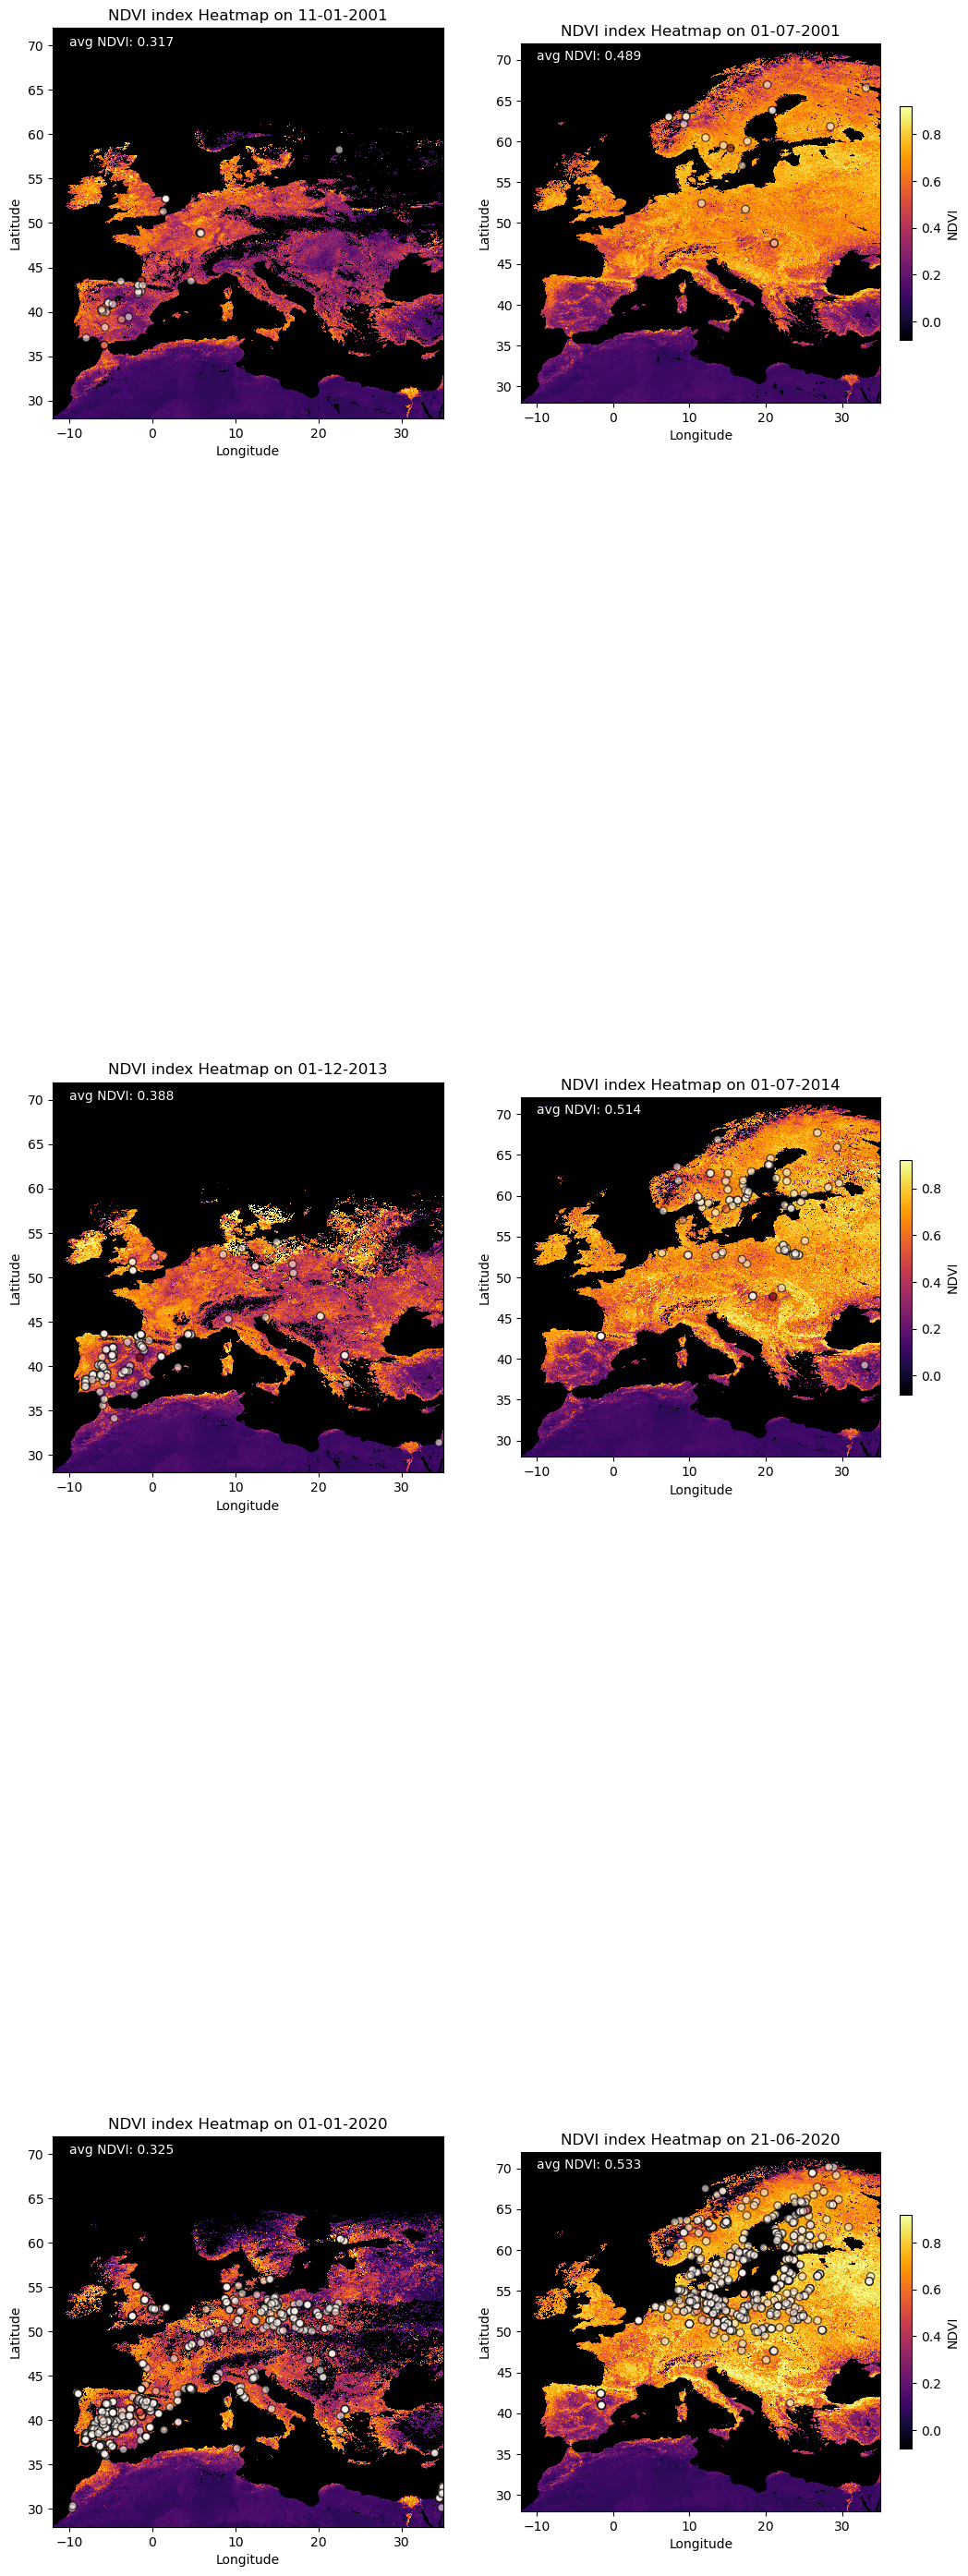

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 42))
cmap = cm.get_cmap("inferno").copy()
cmap.set_bad(color="black")
axes = axes.flatten()
latmin, latmax = 28, 72
lonmin, lonmax = -12, 35

summer = True

summer_months = [6,7,8]
winter_months = [11,12,1,2]

#Chooses specific date files to plot for time and space efficiency
bird_test_filepath = [r"C:\Users\ollie\MSc Data Science\Programming\currentndvidata\c_gls_NDVI_200101110000_GLOBE_VGT_V3.0.1.nc",
                      r"C:\Users\ollie\MSc Data Science\Programming\currentndvidata\c_gls_NDVI_200107010000_GLOBE_VGT_V3.0.1.nc",
                      r"C:\Users\ollie\MSc Data Science\Programming\currentndvidata\c_gls_NDVI_201312010000_GLOBE_VGT_V3.0.1.nc",
                      r"C:\Users\ollie\MSc Data Science\Programming\currentndvidata\c_gls_NDVI_201407010000_GLOBE_PROBAV_V3.0.1.nc",
                      r"C:\Users\ollie\MSc Data Science\Programming\currentndvidata\c_gls_NDVI_202001010000_GLOBE_PROBAV_V3.0.1.nc",
                      r"C:\Users\ollie\MSc Data Science\Programming\currentndvidata\c_gls_NDVI_202006210000_GLOBE_PROBAV_V3.0.1.nc"]

summer_ndvis = []
#summer_lats = []
#summer_lons = []

winter_ndvis = []
winter_lats = []
winter_lons = []

bar = True

for i, filepath in enumerate(bird_test_filepath):
    if i%2 == 1: # Only plot NDVI bar for the right hand plot within each row
        bar = True
    else:
        bar = False
    c, date1, ds = ndvi_xarray_processing(filepath, latmin, latmax, lonmin, lonmax, axes[i], cmap, plotting = True, bar = bar)

    match = re.search(r'\d{8}', filepath)
    date = pd.to_datetime(match[0], format="%Y%m%d")

    print(date.month)
    
    if date.month in winter_months:
        summer = False

    obs_df = crane_by_date(filtered_crane_df, pd.Timestamp(date), summer, latmin, latmax, lonmin, lonmax)
    scatter = axes[i].scatter(obs_df['LONGITUDE'], obs_df['LATITUDE'], 
                          c=obs_df['OBSERVATION COUNT'], cmap='Reds', alpha=0.6, edgecolors='black')
    
    del ds
    
# cbar1 = plt.colorbar(c, ax=axes, orientation="vertical", fraction=0.03, pad=0.05)
# cbar1.set_label('NDVI')

# cbar2 = plt.colorbar(scatter, ax=axes, orientation = "horizontal", pad = 0.1)
# cbar2.set_label('Observation Count')

plt.show()
del c


New Month Analysis: 2001
Pearson correlation: 0.5561543352393876, p-value: 4.1360829682097555e-10


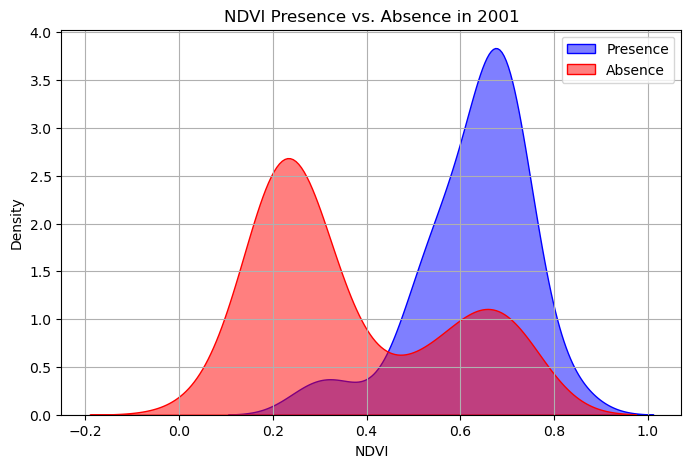

New Month Analysis: 2002
Pearson correlation: 0.435749167822622, p-value: 3.0697140436374614e-05


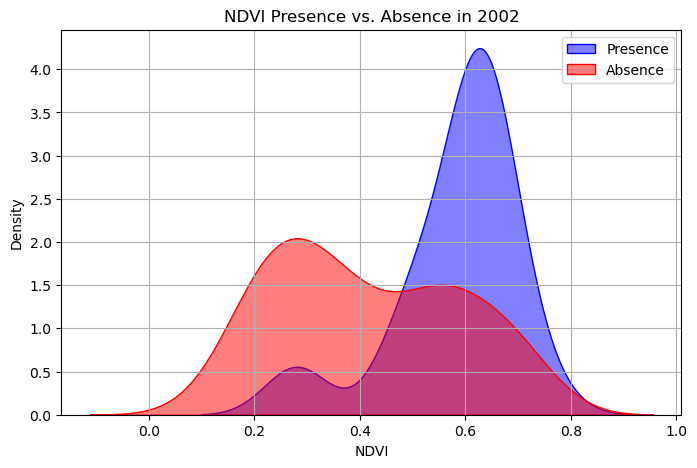

New Month Analysis: 2003
Pearson correlation: 0.5692702465115967, p-value: 3.1956463649353485e-09


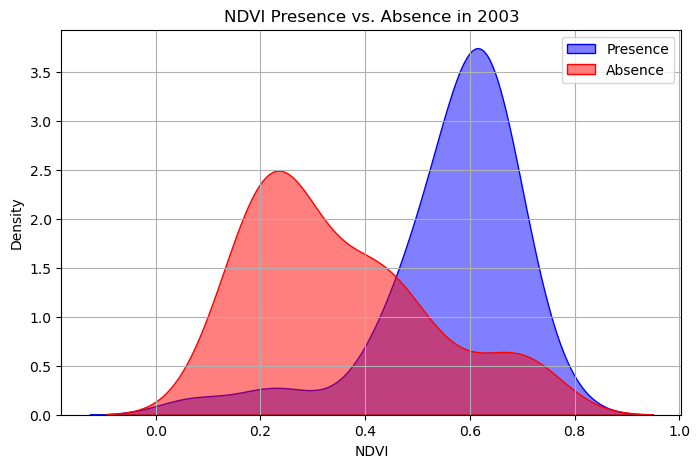

New Month Analysis: 2004
Pearson correlation: 0.4901238502513321, p-value: 1.5343854553780603e-08


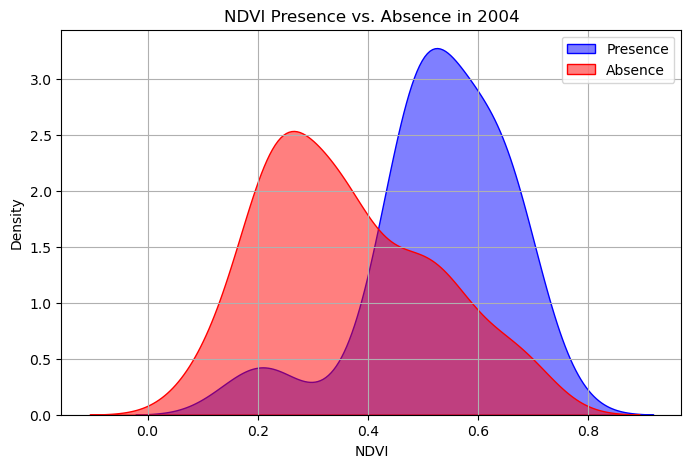

New Month Analysis: 2005
Pearson correlation: 0.6262870245867265, p-value: 2.4428401256177743e-11


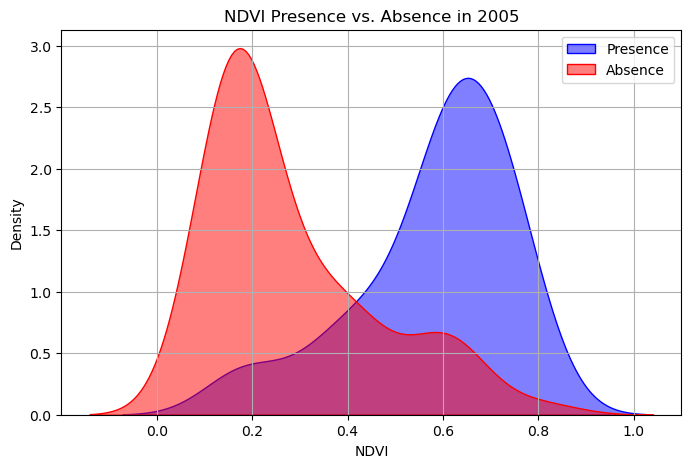

New Month Analysis: 2006
Pearson correlation: 0.5749208133088892, p-value: 8.04129785482254e-12


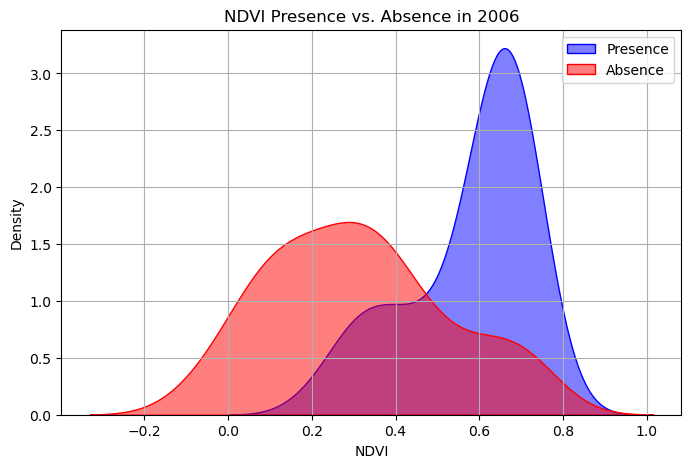

New Month Analysis: 2007
Pearson correlation: 0.555278028149467, p-value: 6.462348064432467e-14


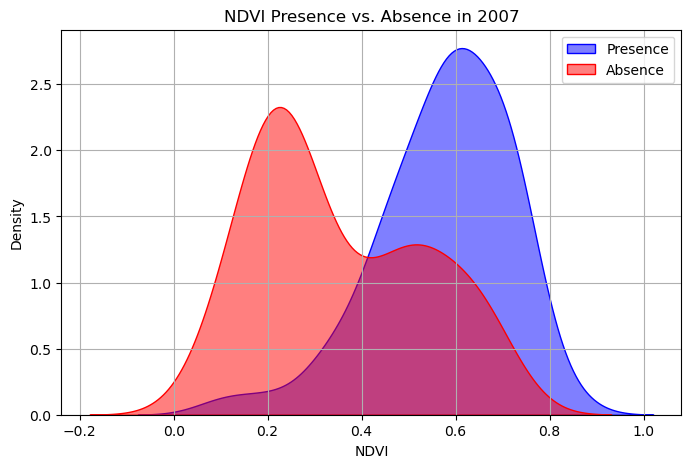

New Month Analysis: 2008
Pearson correlation: 0.6395415139263382, p-value: 1.965913821673645e-19


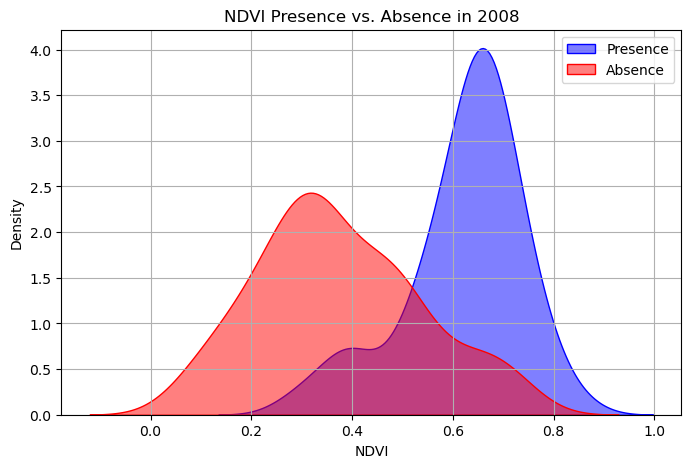

New Month Analysis: 2009
Pearson correlation: 0.622750216681363, p-value: 7.459695620755079e-20


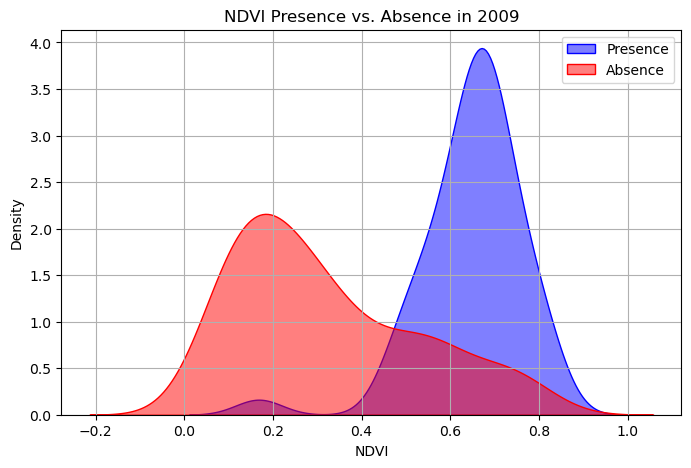

New Month Analysis: 2010
Pearson correlation: 0.6108132877928888, p-value: 2.998024986486549e-22


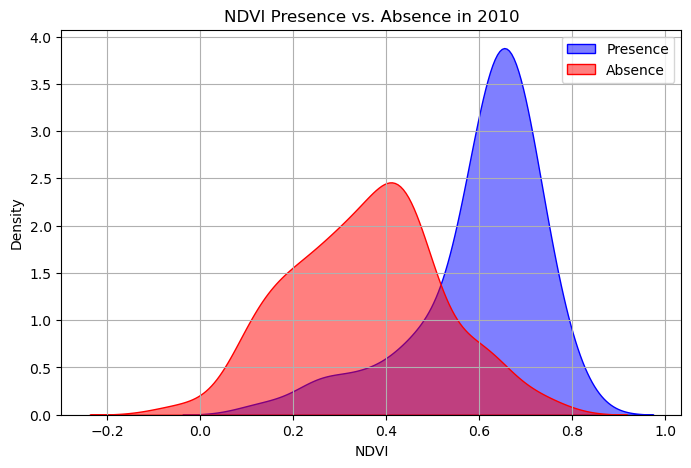

New Month Analysis: 2011
Pearson correlation: 0.7064487010473834, p-value: 8.468588786418518e-39


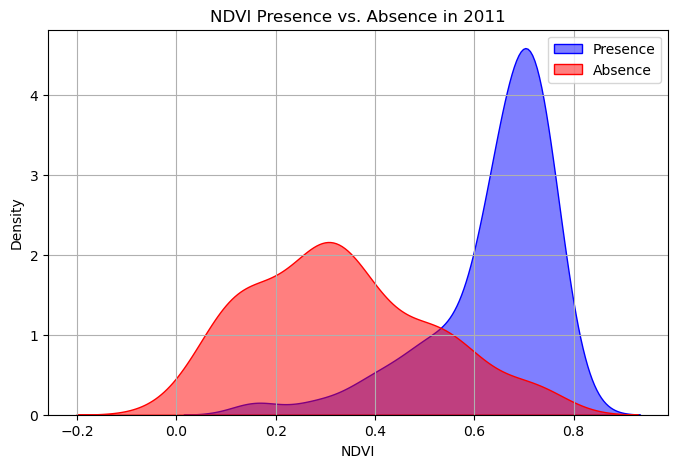

New Month Analysis: 2012
Pearson correlation: 0.719915567278663, p-value: 9.852969666220877e-52


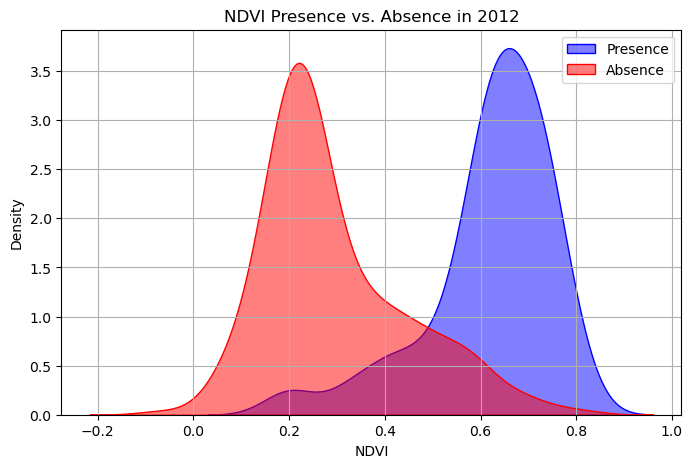

New Month Analysis: 2013
Pearson correlation: 0.5691980818865665, p-value: 4.554502069183812e-33


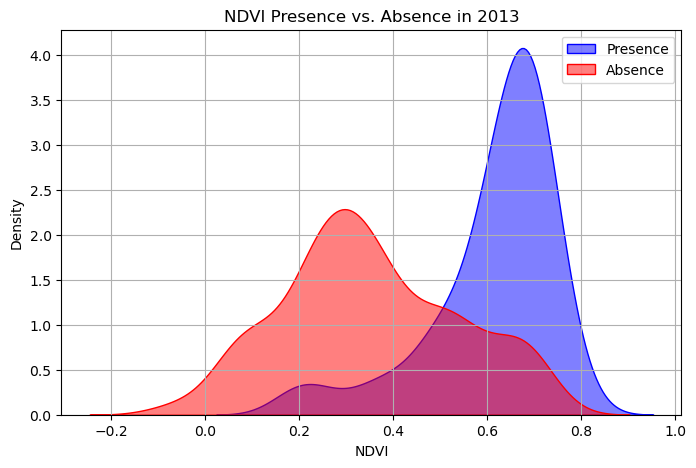

New Month Analysis: 2014
Pearson correlation: 0.5669895634195093, p-value: 5.065817664721296e-54


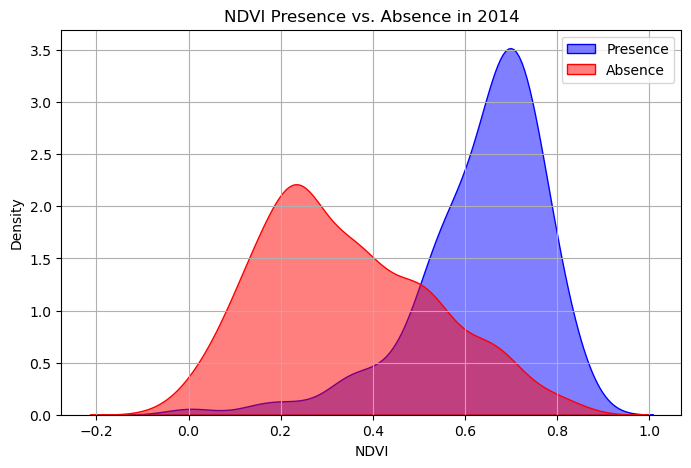

New Month Analysis: 2015
Pearson correlation: 0.44188206962176435, p-value: 5.199487014470436e-35


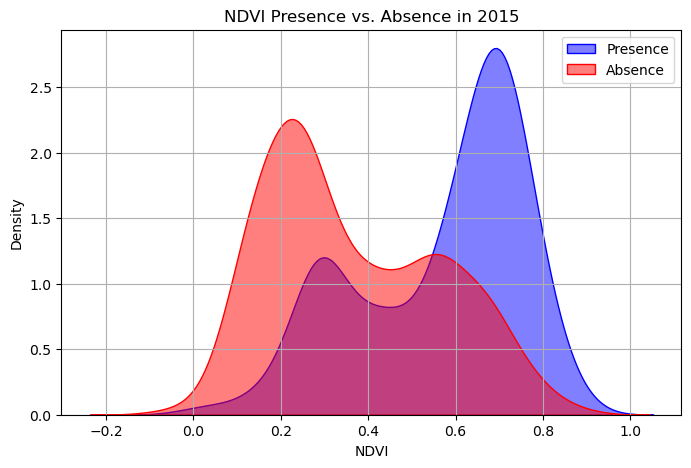

New Month Analysis: 2016
Pearson correlation: 0.642266846396119, p-value: 2.207464698295725e-111


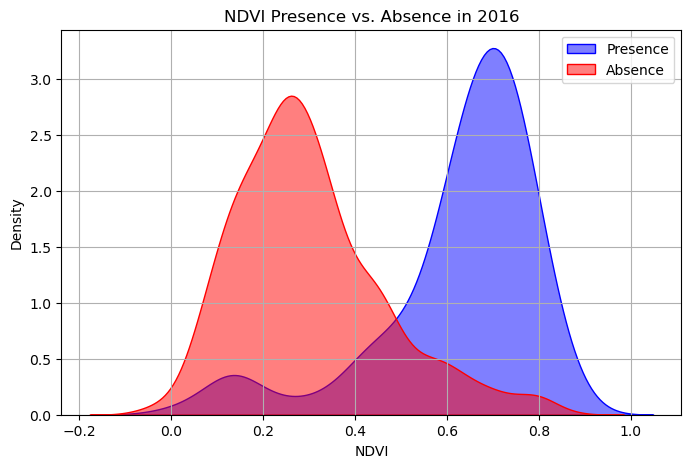

New Month Analysis: 2017
Pearson correlation: 0.6379355606969168, p-value: 1.4368577981927379e-215


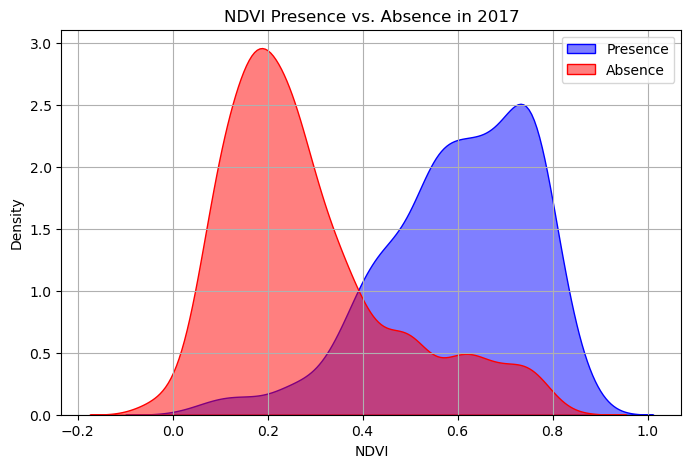

New Month Analysis: 2018
Pearson correlation: 0.5733942567476557, p-value: 9.926896146022656e-211


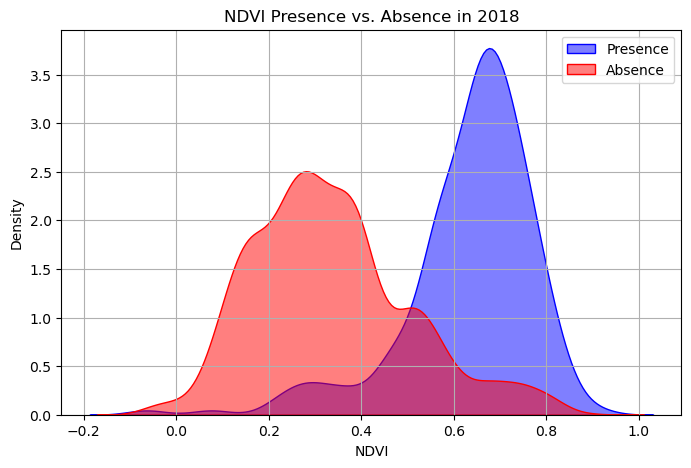

New Month Analysis: 2019
Pearson correlation: 0.5623588464379805, p-value: 6.847518986739936e-249


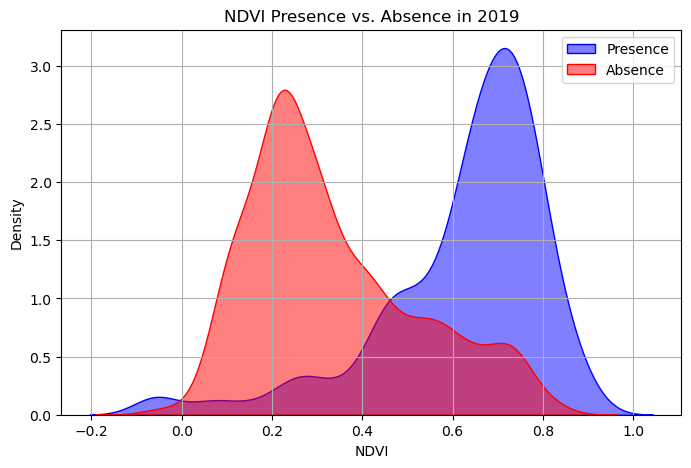

New Month Analysis: 2020
[]
Pearson correlation: nan, p-value: nan


C:\Users\ollie\anaconda3\envs\testing\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


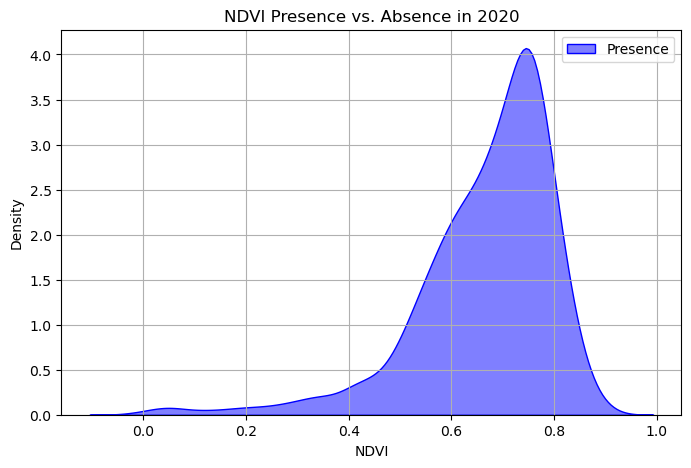

In [15]:
# Distribution analysis per year
for i in range(2001, 2021):
    print(f"New Month Analysis: {i}")
    presence_ndvi = crane_ndvi[(crane_ndvi["OBSERVATION DATE"].dt.year == i) & (crane_ndvi["OBSERVATION DATE"].dt.month == 6)]["NDVI"].values
    absence_ndvi = crane_absence_ndvi[(crane_absence_ndvi["date"].dt.year == i)  & (crane_absence_ndvi["date"].dt.month == 6)]["Crane non presence ndvi"].values
    if i == 2020:
        print(absence_ndvi)

    # Removes NaNs for correlation analysis
    presence_ndvi_wo_nans = presence_ndvi[~np.isnan(presence_ndvi)]
    absence_ndvi_wo_nans = absence_ndvi[~np.isnan(absence_ndvi)]

    #Creates presence and absence labels
    presence_labels = np.ones(len(presence_ndvi_wo_nans))
    absence_labels = np.zeros(len(absence_ndvi_wo_nans))
    
    all_ndvis = np.concatenate((presence_ndvi_wo_nans, absence_ndvi_wo_nans))
    all_labels = np.concatenate((presence_labels, absence_labels))

    corr, pvalue = pearsonr(all_ndvis, all_labels)
    print(f"Pearson correlation: {corr}, p-value: {pvalue}")
    
    # Plots presence and absence distributions
    plt.figure(figsize = (8,5))
    sns.kdeplot(presence_ndvi_wo_nans, label = "Presence", fill = True, color = "Blue", alpha = 0.5)
    sns.kdeplot(absence_ndvi_wo_nans, label = "Absence", fill = True, color = "Red", alpha = 0.5)
    plt.xlabel("NDVI")
    plt.ylabel("Density")
    plt.title(f"NDVI Presence vs. Absence in {i}")
    plt.legend()
    plt.grid()
    plt.show()


    #Logistic regression analysis done per year, can easily be un-commented and used
    # X = all_ndvis.reshape(-1,1)
    # y = np.copy(all_labels)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # model = LogisticRegression()
    # model.fit(X_train, y_train)
    
    # # Predict on test set
    # y_pred = model.predict(X_test)
    # y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # # Evaluate the model
    # accuracy = accuracy_score(y_test, y_pred)
    # #roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # print(f"Accuracy: {accuracy:.3f}")
    # #print(f"AUC-ROC Score: {roc_auc:.3f}")

    # ndvi_range = np.linspace(min(X), max(X), 100).reshape(-1, 1)
    # probabilities = model.predict_proba(ndvi_range)[:, 1]
    
    # # Plot logistic function
    # plt.figure(figsize=(8, 5))
    # plt.plot(ndvi_range, probabilities, color="blue", label="Logistic Regression Curve")
    # plt.scatter(X_test, y_test, alpha=0.3, color="red", label="Actual Data")
    # plt.xlabel("NDVI")
    # plt.ylabel("Probability of Crane Presence")
    # plt.title("Logistic Regression Model: NDVI vs. Crane Presence")
    # plt.legend()
    # plt.grid()
    # plt.show()
    
    


Pearson correlation: 0.47902016512542495, p-value: 0.0


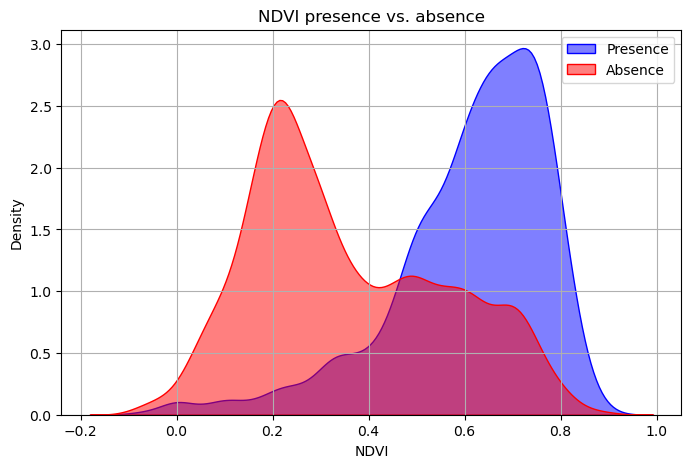

Accuracy: 0.813


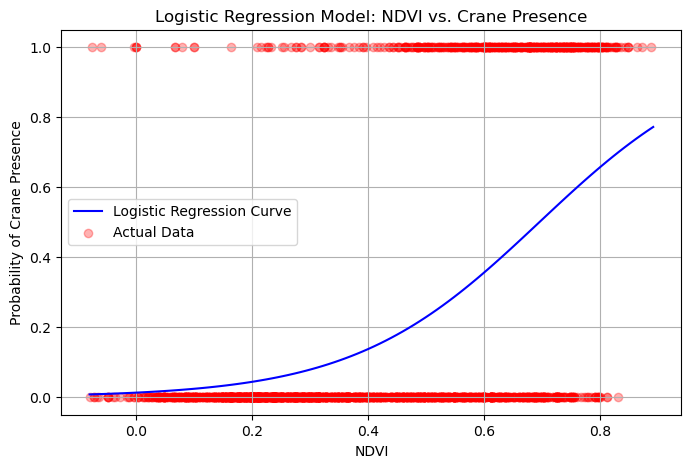

In [3]:
# Distribution analysis on every year combined alongside logistic regression analysis

presence_ndvi = crane_ndvi[(crane_ndvi["OBSERVATION DATE"].dt.month == 7)]["NDVI"].values
absence_ndvi = crane_absence_ndvi[(crane_absence_ndvi["date"].dt.month == 7)]["Crane non presence ndvi"].values

presence_ndvi_wo_nans = presence_ndvi[~np.isnan(presence_ndvi)]
absence_ndvi_wo_nans = absence_ndvi[~np.isnan(absence_ndvi)]

presence_labels = np.ones(len(presence_ndvi_wo_nans))
absence_labels = np.zeros(len(absence_ndvi_wo_nans))

all_ndvis = np.concatenate((presence_ndvi_wo_nans, absence_ndvi_wo_nans))
all_labels = np.concatenate((presence_labels, absence_labels))

corr, pvalue = pearsonr(all_ndvis, all_labels)

print(f"Pearson correlation: {corr}, p-value: {pvalue}")


plt.figure(figsize = (8,5))
sns.kdeplot(presence_ndvi_wo_nans, label = "Presence", fill = True, color = "Blue", alpha = 0.5)
sns.kdeplot(absence_ndvi_wo_nans, label = "Absence", fill = True, color = "Red", alpha = 0.5)
plt.xlabel("NDVI")
plt.ylabel("Density")
plt.title("NDVI presence vs. absence")
plt.legend()
plt.grid()
plt.show()

X = all_ndvis.reshape(-1,1)
y = np.copy(all_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.3f}")
#print(f"AUC-ROC Score: {roc_auc:.3f}")

ndvi_range = np.linspace(min(X), max(X), 100).reshape(-1, 1)
probabilities = model.predict_proba(ndvi_range)[:, 1]

# Plot logistic function
plt.figure(figsize=(8, 5))
plt.plot(ndvi_range, probabilities, color="blue", label="Logistic Regression Curve")
plt.scatter(X_test, y_test, alpha=0.3, color="red", label="Actual Data")
plt.xlabel("NDVI")
plt.ylabel("Probability of Crane Presence")
plt.title("Logistic Regression Model: NDVI vs. Crane Presence")
plt.legend()
plt.grid()
plt.show()